### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [70]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt


#example_matrix = np.array([[5.45, 11.14], [11.14, 1.42]])
#example_matrix = np.array([[18.45, 1.14], [1.14, 15.82]])
#example_matrix = np.array([[1.45, 5.14], [5.14, 7.82]])
#example_matrix = np.array([[13.45, 3.4], [3.4, 1.82]])
example_matrix=np.random.rand(4,4)

big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])
#example_matrix = np.array([[1.5, 0.5, 1.5, 0.4], [0.5, 2, 2.9, 1.5], [0.3,0.5, 2.5, 1.6], [0.5, 0.5, 0.5, 2.5]])
#example_matrix = np.array([[1.7, 0.2, 1.5, 0.2], [0.7, 1, 2.9, 1.1], [0.5,1.5, .7, 1.6], [0.5, 1.5, 0.5, 1.7]])
example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix = np.array([[1.5, .5], [.5, 1.5]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.02435132 0.0276953  0.00833261 0.0243176  0.0276953  0.14405572
 0.06414766 0.14035989 0.00833261 0.06414766 0.04771253 0.05076805
 0.0243176  0.14035989 0.05076805 0.1526382 ]


In [71]:
eig,e_v=np.linalg.eig(example_matrix)
#b=np.array([3.,1.])
b=np.array([3.,2.,1.,0])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)

(array([[ 1.89476716,  0.40023778, -0.23993829,  0.26594019],
        [ 0.40023778,  1.15078492,  0.79431624,  1.15185079],
        [-0.23993829,  0.79431624,  1.47185875,  0.3381907 ],
        [ 0.26594019,  1.15185079,  0.3381907 ,  1.48258917]]),
 (array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 2.46051075e-16]),
  array([[-0.28070725, -0.86921831,  0.38379234,  0.13552277],
         [-0.61700217,  0.06024846, -0.0380806 , -0.78372719],
         [-0.41147342,  0.4906775 ,  0.69454936,  0.32791219],
         [-0.60926299,  0.00807813, -0.60733392,  0.50978315]])))

In [72]:
example_matrix=BB

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.25643876 0.01144216 0.00411217 0.00505173 0.01144216 0.09459328
 0.04506702 0.09476859 0.00411217 0.04506702 0.15474058 0.0081695
 0.00505173 0.09476859 0.0081695  0.15700505]


In [73]:
example_matrix

array([[ 1.89476716,  0.40023778, -0.23993829,  0.26594019],
       [ 0.40023778,  1.15078492,  0.79431624,  1.15185079],
       [-0.23993829,  0.79431624,  1.47185875,  0.3381907 ],
       [ 0.26594019,  1.15185079,  0.3381907 ,  1.48258917]])

In [74]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 2.46051075e-16]),
 array([[-0.28070725, -0.86921831,  0.38379234,  0.13552277],
        [-0.61700217,  0.06024846, -0.0380806 , -0.78372719],
        [-0.41147342,  0.4906775 ,  0.69454936,  0.32791219],
        [-0.60926299,  0.00807813, -0.60733392,  0.50978315]]))

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [75]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.log2(len(example_matrix)))*2+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.log2(len(example_matrix)))*2)))]

    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    print(nodes)
    #add root tree
    nodes.insert(0, 1)

    idx_sub=1
    thetas=[]
    for i in range(len(nodes)-len(input_probabilities)):
        right_node=i+idx_sub
        left_node=right_node+1
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [76]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [77]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.7231292203636361
1 -> 0.6907127700110081
00 -> 0.5263504697557694
01 -> 0.49585386187020986
10 -> 0.4605315102215057
11 -> 0.5147765134010865
000 -> 0.5175721391812774
001 -> 0.0957282495161979
010 -> 0.3256308387749678
011 -> 0.3739459976658556
100 -> 0.22176381879227608
101 -> 0.4036212092811369
110 -> 0.3159435322971718
111 -> 0.4064167112078008
0000 -> 0.5063978242161675
0001 -> 0.10696804609702429
0010 -> 0.06412620460780433
0011 -> 0.07107550659709334
0100 -> 0.10696804609702433
0101 -> 0.30756020593612876
0110 -> 0.21228994608301988
0111 -> 0.3078450713628214
1000 -> 0.06412620460780433
1001 -> 0.21228994608301988
1010 -> 0.3933707975730531
1011 -> 0.09038526538273464
1100 -> 0.07107550659709334
1101 -> 0.3078450713628214
1110 -> 0.09038526538273464
1111 -> 0.3962386237491968
[0.7231292203636361, 0.6907127700110081, 0.5263504697557694, 0.49585386187020986, 0.4605315102215057, 0.5147765134010865, 0.5175721391812774, 0.0957282495161979, 0.3256308387749678, 0.373945997665855

┌────────────┐┌───┐              ┌───┐              ┌───┐               »
q_0: ┤ Ry(1.5249) ├┤ X ├──────■───────┤ X ├──────■───────┤ X ├───────■───────»
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐├───┤       │       »
q_1: ───────────────────┤ Ry(1.5111) ├─────┤ Ry(1.6819) ├┤ X ├───────■───────»
                        └────────────┘     └────────────┘└───┘┌──────┴──────┐»
q_2: ─────────────────────────────────────────────────────────┤ Ry(0.36578) ├»
                                                              └─────────────┘»
q_3: ────────────────────────────────────────────────────────────────────────»
                                                                             »
«     ┌───┐┌───┐              ┌───┐                               ┌───┐»
«q_0: ┤ X ├┤ X ├──────■───────┤ X ├──────■─────────────────■──────┤ X ├»
«     ├───┤└───┘      │       ├───┤      │       ┌───┐     │      ├───┤»
«q_1: ┤ X ├───────────■───────┤ X ├──────■───────┤ X ├─────■──────┤ X ├»
«     └───┘     ┌─────┴──────┐└───┘┌─────┴──────┐└───┘┌────┴─────┐├───┤»
«q_2: ──────────┤ Ry(1.7087) ├─────┤ Ry(2.1368) ├─────┤ Ry(1.82) ├┤ X ├»
«               └────────────┘     └────────────┘     └──────────┘└───┘»
«q_3: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«                    ┌───┐┌───┐              ┌───┐┌───┐              ┌───┐┌───┐»
«q_0: ───────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├»
«            │       ├───┤├───┤      │       ├───┤└───┘      │       └───┘└───┘»
«q_1: ───────■───────┤ X ├┤ X ├──────■───────┤ X ├───────────■─────────────────»
«            │       ├───┤└───┘      │       ├───┤           │       ┌───┐     »
«q_2: ───────■───────┤ X ├───────────■───────┤ X ├───────────■───────┤ X ├─────»
«     ┌──────┴──────┐└───┘     ┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘     »
«q_3: ┤ Ry(0.41635) ├──────────┤ Ry(1.6735) ├──────────┤ Ry(2.4722) ├──────────»
«     └─────────────┘          └────────────┘          └────────────┘          »
«                   ┌───┐                                           »
«q_0: ──────■───────┤ X ├──────■───────────────────────■────────────»
«           │       ├───┤      │       ┌───┐┌───┐      │       ┌───┐»
«q_1: ──────■───────┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├»
«           │       ├───┤      │       ├───┤└───┘      │       ├───┤»
«q_2: ──────■───────┤ X ├──────■───────┤ X ├───────────■───────┤ X ├»
«     ┌─────┴──────┐└───┘┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘»
«q_3: ┤ Ry(1.9342) ├─────┤ Ry(2.5549) ├──────────┤ Ry(0.4517) ├─────»
«     └────────────┘     └────────────┘          └────────────┘     »
«                                      
«q_0: ──────■──────────────────■───────
«           │                  │       
«q_1: ──────■──────────────────■───────
«           │       ┌───┐      │       
«q_2: ──────■───────┤ X ├──────■───────
«     ┌─────┴──────┐└───┘┌─────┴──────┐
«q_3: ┤ Ry(2.6878) ├─────┤ Ry(2.6931) ├
«     └────────────┘     └────────────┘

In [78]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'0000': 0.256438756370869,
 '0001': 0.004112170117402,
 '0010': 0.011442162885815,
 '0011': 0.005051727638033,
 '0100': 0.004112170117402,
 '0101': 0.15474058438326,
 '0110': 0.045067021207932,
 '0111': 0.008169496198307,
 '1000': 0.011442162885815,
 '1001': 0.045067021207932,
 '1010': 0.094593280275474,
 '1011': 0.094768587962381,
 '1100': 0.005051727638034,
 '1101': 0.008169496198307,
 '1110': 0.094768587962381,
 '1111': 0.157005046950658}

In [79]:
#Unitary for PE
resolution = 2
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_2427/4115894098.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[-0.73717404+0.0685j    , -0.05384382-0.18781202j,
            0.47094543+0.15105915j,  0.07610888-0.40411464j],
          [-0.05384382-0.18781202j,  0.61059844-0.37924155j,
           -0.28655626-0.28032885j, -0.40001761-0.35278895j],
          [ 0.47094543+0.15105915j, -0.28655626-0.28032885j,
           -0.133238  +0.31308844j,  0.16320035-0.67251891j],
          [ 0.07610888-0.40411464j, -0.40001761-0.35278895j,
            0.16320035-0.67251891j,  0.25981361-0.0023469j ]],
         input_dims=(2, 2), output_dims=(2, 2))

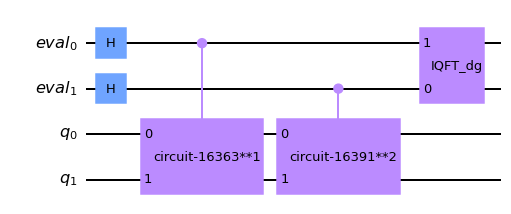

In [80]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

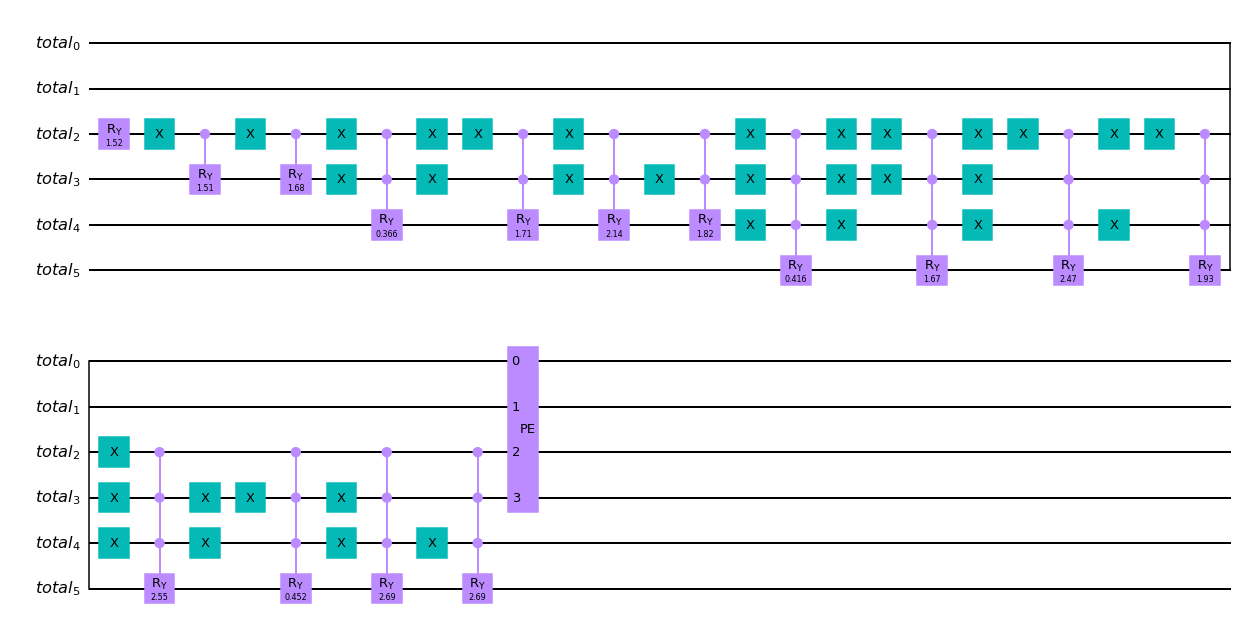

In [81]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [82]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [83]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [84]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
ss=attach_bitstrings(statevector)
ss

[('000000', (0.0122-0j)),
 ('000001', (0.3331+0j)),
 ('000010', (0.0856+0j)),
 ('000011', (0.0755+0j)),
 ('000100', (-0.0703-0j)),
 ('000101', (-0.0231-0j)),
 ('000110', (-0.0085-0j)),
 ('000111', (0.166+0j)),
 ('001000', (0.0294+0j)),
 ('001001', (-0.1881-0j)),
 ('001010', (0.1549+0j)),
 ('001011', (0.1107+0j)),
 ('001100', (0.0457+0j)),
 ('001101', (-0.0031-0j)),
 ('001110', (-0.1355-0j)),
 ('001111', (0.1639+0j)),
 ('010000', (-0.0249-0j)),
 ('010001', (-0.0633-0j)),
 ('010010', (0.0392+0j)),
 ('010011', (0.1132+0j)),
 ('010100', (0.1441+0j)),
 ('010101', (0.0044-0j)),
 ('010110', (-0.0039-0j)),
 ('010111', (0.2487+0j)),
 ('011000', (-0.0603-0j)),
 ('011001', (0.0357+0j)),
 ('011010', (0.071+0j)),
 ('011011', (0.1659+0j)),
 ('011100', (-0.0938-0j)),
 ('011101', (0.0006-0j)),
 ('011110', (-0.0621-0j)),
 ('011111', (0.2456+0j)),
 ('100000', (0.0144+0j)),
 ('100001', (-0.0636-0j)),
 ('100010', (0.0229+0j)),
 ('100011', (0.1334+0j)),
 ('100100', (-0.083-0j)),
 ('100101', (0.0044+0j)),
 

In [85]:
a=[i[1] for i in ss if i[0][-2:]=='11']
aa=np.array(a)
aa

array([0.0755+0.j, 0.166 +0.j, 0.1107+0.j, 0.1639+0.j, 0.1132+0.j,
       0.2487+0.j, 0.1659+0.j, 0.2456+0.j, 0.1334+0.j, 0.2932+0.j,
       0.1955+0.j, 0.2895+0.j, 0.1246+0.j, 0.2738+0.j, 0.1826+0.j,
       0.2704+0.j])

In [86]:
nf=np.sqrt((1/(sum(aa**2))))
aa*=nf
aa

array([0.09310175+0.j, 0.20470053+0.j, 0.13650813+0.j, 0.20211095+0.j,
       0.13959097+0.j, 0.30668086+0.j, 0.20457722+0.j, 0.30285814+0.j,
       0.16450031+0.j, 0.3615554 +0.j, 0.24107804+0.j, 0.3569928 +0.j,
       0.15364871+0.j, 0.33763257+0.j, 0.22517059+0.j, 0.3334399 +0.j])

# Computing Probabilities

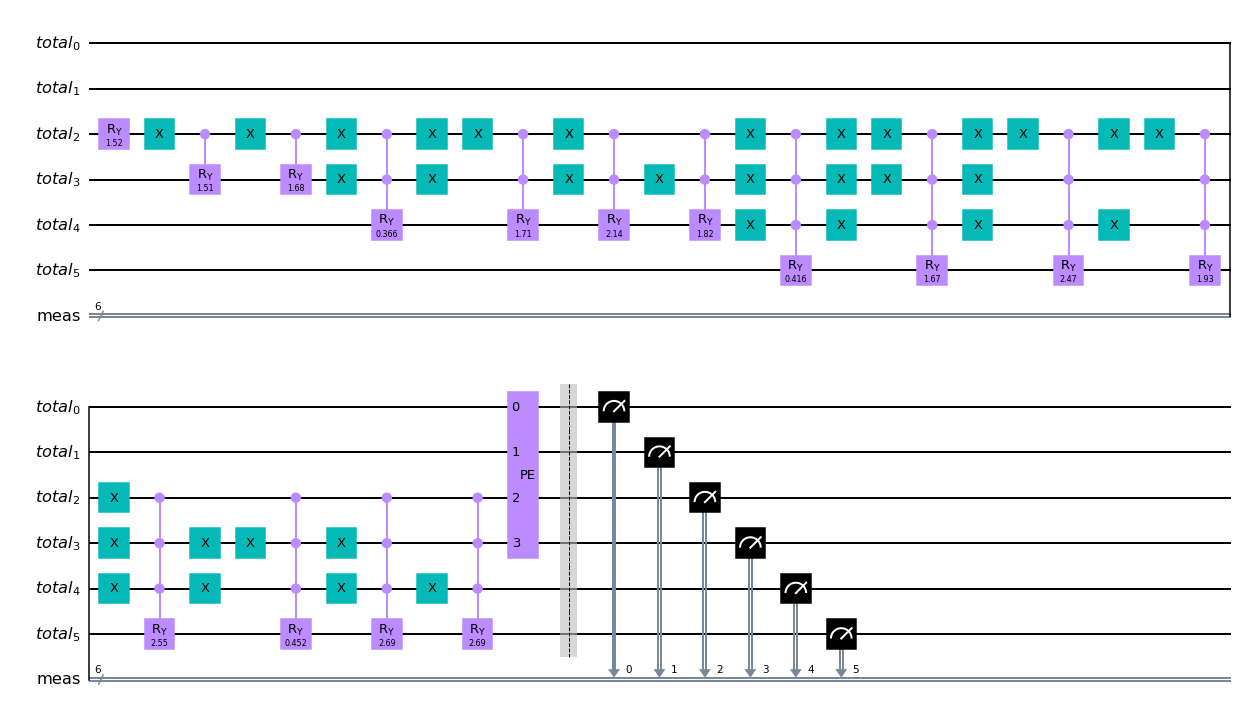

In [87]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=1).draw("mpl")

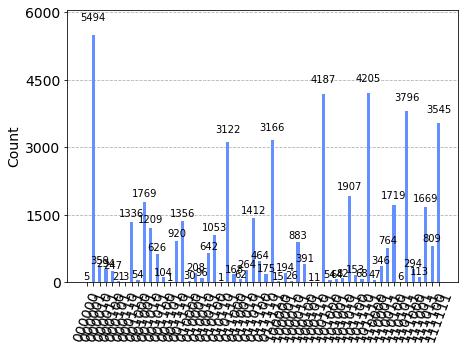

In [88]:
n_shots=50000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [89]:
for i in counts:
    counts[i]/=n_shots
counts

{'001101': 2e-05,
 '000110': 6e-05,
 '010010': 0.00192,
 '100000': 0.0003,
 '000000': 0.0001,
 '110001': 0.00692,
 '000101': 0.00042,
 '101010': 0.00164,
 '100010': 0.00052,
 '100011': 0.01766,
 '110111': 0.07592,
 '011001': 0.00124,
 '100110': 2e-05,
 '010000': 0.0006,
 '100001': 0.00388,
 '111001': 0.00226,
 '100100': 0.00782,
 '000100': 0.00494,
 '010110': 2e-05,
 '010111': 0.06244,
 '010001': 0.00416,
 '101011': 0.03814,
 '011011': 0.02824,
 '001001': 0.03538,
 '001011': 0.01252,
 '011100': 0.00928,
 '101111': 0.0841,
 '001000': 0.00108,
 '111100': 0.01618,
 '000010': 0.00718,
 '111000': 0.00588,
 '110011': 0.01528,
 '111111': 0.0709,
 '001010': 0.02418,
 '110101': 0.00012,
 '001111': 0.02712,
 '011111': 0.06332,
 '001110': 0.0184,
 '010011': 0.01284,
 '011000': 0.00336,
 '111011': 0.03338,
 '110000': 0.00094,
 '100111': 0.08374,
 '101100': 0.00306,
 '101001': 0.00128,
 '000011': 0.00588,
 '101110': 0.00136,
 '110100': 0.03438,
 '011010': 0.00528,
 '100101': 2e-05,
 '000001': 0.109

In [90]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([1.0000e-04, 1.0988e-01, 7.1800e-03, 5.8800e-03, 4.9400e-03,
       4.2000e-04, 6.0000e-05, 2.6720e-02, 1.0800e-03, 3.5380e-02,
       2.4180e-02, 1.2520e-02, 2.0800e-03, 2.0000e-05, 1.8400e-02,
       2.7120e-02, 6.0000e-04, 4.1600e-03, 1.9200e-03, 1.2840e-02,
       2.1060e-02, 0.0000e+00, 2.0000e-05, 6.2440e-02, 3.3600e-03,
       1.2400e-03, 5.2800e-03, 2.8240e-02, 9.2800e-03, 0.0000e+00,
       3.5000e-03, 6.3320e-02, 3.0000e-04, 3.8800e-03, 5.2000e-04,
       1.7660e-02, 7.8200e-03, 2.0000e-05, 2.0000e-05, 8.3740e-02,
       1.0800e-03, 1.2800e-03, 1.6400e-03, 3.8140e-02, 3.0600e-03,
       0.0000e+00, 1.3600e-03, 8.4100e-02, 9.4000e-04, 6.9200e-03,
       0.0000e+00, 1.5280e-02, 3.4380e-02, 1.2000e-04, 0.0000e+00,
       7.5920e-02, 5.8800e-03, 2.2600e-03, 0.0000e+00, 3.3380e-02,
       1.6180e-02, 0.0000e+00, 0.0000e+00, 7.0900e-02])

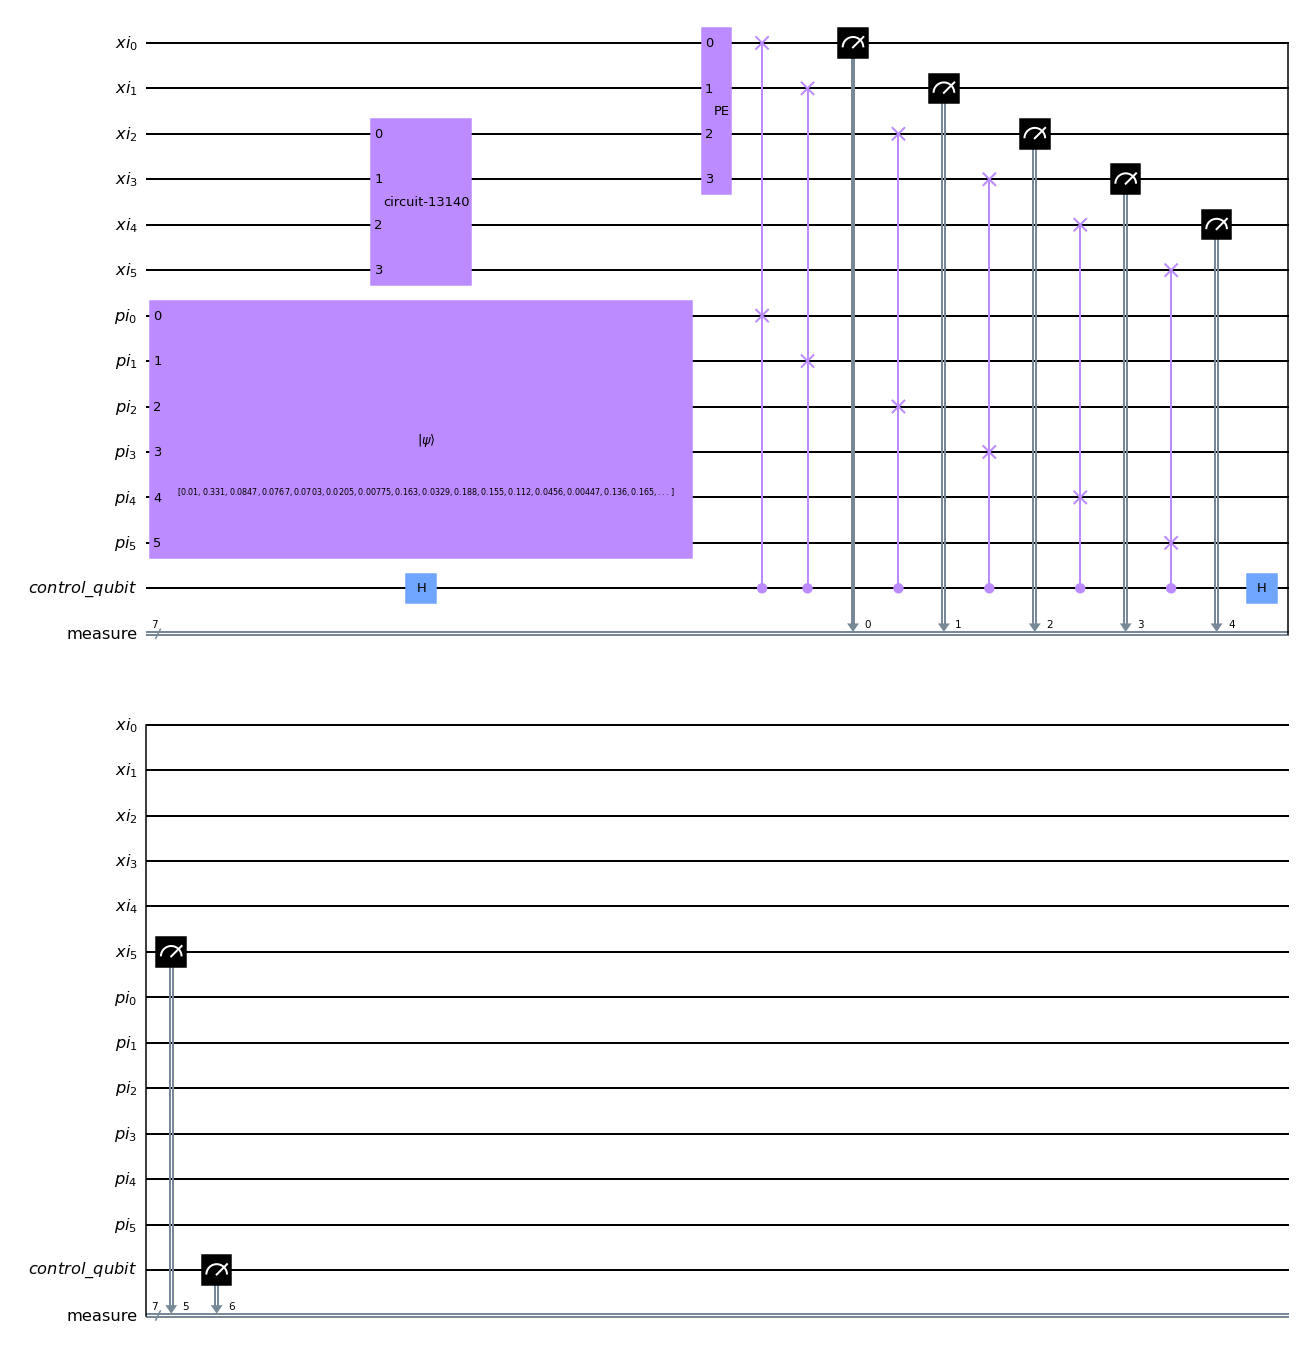

In [91]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_2.h(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

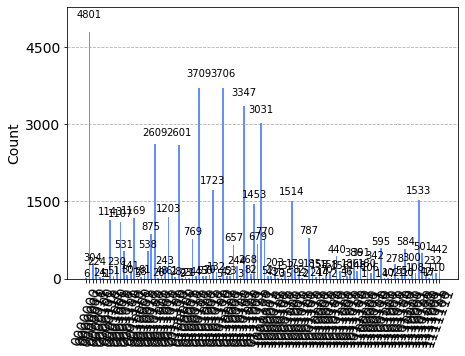

In [92]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [93]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([6.000e+00, 4.801e+03, 3.040e+02, 2.240e+02, 2.400e+01, 5.000e+00,
       1.000e+00, 1.143e+03, 5.100e+01, 2.300e+02, 1.107e+03, 5.310e+02,
       8.000e+01, 0.000e+00, 1.410e+02, 1.169e+03, 5.000e+00, 2.800e+01,
       8.100e+01, 5.380e+02, 8.750e+02, 0.000e+00, 0.000e+00, 2.609e+03,
       2.000e+01, 4.800e+01, 2.430e+02, 1.203e+03, 6.100e+01, 0.000e+00,
       2.800e+01, 2.601e+03, 9.000e+00, 2.300e+01, 2.100e+01, 7.690e+02,
       4.400e+01, 0.000e+00, 0.000e+00, 3.709e+03, 5.300e+01, 5.000e+01,
       7.000e+01, 1.723e+03, 1.320e+02, 0.000e+00, 5.000e+00, 3.706e+03,
       4.200e+01, 5.300e+01, 0.000e+00, 6.570e+02, 2.440e+02, 3.000e+00,
       0.000e+00, 3.347e+03, 2.680e+02, 8.200e+01, 0.000e+00, 1.453e+03,
       6.790e+02, 0.000e+00, 0.000e+00, 3.031e+03])

In [94]:
statevector

array([1.0000e-04, 1.0988e-01, 7.1800e-03, 5.8800e-03, 4.9400e-03,
       4.2000e-04, 6.0000e-05, 2.6720e-02, 1.0800e-03, 3.5380e-02,
       2.4180e-02, 1.2520e-02, 2.0800e-03, 2.0000e-05, 1.8400e-02,
       2.7120e-02, 6.0000e-04, 4.1600e-03, 1.9200e-03, 1.2840e-02,
       2.1060e-02, 0.0000e+00, 2.0000e-05, 6.2440e-02, 3.3600e-03,
       1.2400e-03, 5.2800e-03, 2.8240e-02, 9.2800e-03, 0.0000e+00,
       3.5000e-03, 6.3320e-02, 3.0000e-04, 3.8800e-03, 5.2000e-04,
       1.7660e-02, 7.8200e-03, 2.0000e-05, 2.0000e-05, 8.3740e-02,
       1.0800e-03, 1.2800e-03, 1.6400e-03, 3.8140e-02, 3.0600e-03,
       0.0000e+00, 1.3600e-03, 8.4100e-02, 9.4000e-04, 6.9200e-03,
       0.0000e+00, 1.5280e-02, 3.4380e-02, 1.2000e-04, 0.0000e+00,
       7.5920e-02, 5.8800e-03, 2.2600e-03, 0.0000e+00, 3.3380e-02,
       1.6180e-02, 0.0000e+00, 0.0000e+00, 7.0900e-02])

In [95]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [96]:
sign_dictionary

{'000000': 1,
 '000001': 1,
 '000010': 1,
 '000011': 1,
 '000100': -1,
 '000101': -1,
 '000110': -1,
 '000111': 1,
 '001000': 1,
 '001001': -1,
 '001010': 1,
 '001011': 1,
 '001100': 1,
 '001101': -1,
 '001110': -1,
 '001111': 1,
 '010000': -1,
 '010001': -1,
 '010010': 1,
 '010011': 1,
 '010100': 1,
 '010101': 0,
 '010110': -1,
 '010111': 1,
 '011000': -1,
 '011001': 1,
 '011010': 1,
 '011011': 1,
 '011100': -1,
 '011101': 0,
 '011110': -1,
 '011111': 1,
 '100000': 1,
 '100001': -1,
 '100010': 1,
 '100011': 1,
 '100100': -1,
 '100101': -1,
 '100110': -1,
 '100111': 1,
 '101000': 1,
 '101001': 1,
 '101010': 1,
 '101011': 1,
 '101100': 1,
 '101101': 0,
 '101110': -1,
 '101111': 1,
 '110000': 1,
 '110001': -1,
 '110010': 0,
 '110011': 1,
 '110100': -1,
 '110101': 1,
 '110110': 0,
 '110111': 1,
 '111000': 1,
 '111001': 1,
 '111010': 0,
 '111011': 1,
 '111100': 1,
 '111101': 0,
 '111110': 0,
 '111111': 1}

In [97]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'000000': 0.01,
 '000001': 0.3314815228636432,
 '000010': 0.08473488065725944,
 '000011': 0.07668115805072326,
 '000100': -0.07028513356322232,
 '000101': -0.020493901531919198,
 '000110': -0.007745966692414834,
 '000111': 0.1634625339336204,
 '001000': 0.03286335345030997,
 '001001': -0.1880957203128237,
 '001010': 0.1554991961394013,
 '001011': 0.11189280584559491,
 '001100': 0.045607017003965515,
 '001101': -0.00447213595499958,
 '001110': -0.13564659966250536,
 '001111': 0.1646815108019112,
 '010000': -0.02449489742783178,
 '010001': -0.0644980619863884,
 '010010': 0.04381780460041329,
 '010011': 0.11331372379372236,
 '010100': 0.1451206394693739,
 '010101': 0.0,
 '010110': -0.00447213595499958,
 '010111': 0.2498799711861677,
 '011000': -0.057965506984757754,
 '011001': 0.03521363372331802,
 '011010': 0.0726636084983398,
 '011011': 0.16804761230080004,
 '011100': -0.09633275663033837,
 '011101': 0.0,
 '011110': -0.05916079783099616,
 '011111': 0.25163465580082567,
 '100000': 0.017

# Eigenvectors reconstruction (2x2 matrix)


In [98]:
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))
l_list

[array([ 0.01      , -0.07028513,  0.03286335,  0.04560702, -0.0244949 ,
         0.14512064, -0.05796551, -0.09633276,  0.01732051, -0.08843076,
         0.03286335,  0.05531727,  0.03065942, -0.18541845,  0.07668116,
         0.12720063]),
 array([ 0.33148152, -0.0204939 , -0.18809572, -0.00447214, -0.06449806,
         0.        ,  0.03521363,  0.        , -0.06228965, -0.00447214,
         0.03577709,  0.        , -0.08318654,  0.01095445,  0.04753946,
         0.        ]),
 array([ 0.08473488, -0.00774597,  0.1554992 , -0.1356466 ,  0.0438178 ,
        -0.00447214,  0.07266361, -0.0591608 ,  0.02280351, -0.00447214,
         0.04049691, -0.03687818,  0.        ,  0.        ,  0.        ,
         0.        ]),
 array([0.07668116, 0.16346253, 0.11189281, 0.16468151, 0.11331372,
        0.24987997, 0.16804761, 0.25163466, 0.13289093, 0.28937864,
        0.19529465, 0.29      , 0.1236123 , 0.27553584, 0.18270194,
        0.26627054])]

In [99]:
for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

# Non eseguire le prossime celle-> si riferiscono ai conti fatti dopo

In [251]:
l_list

[array([ 0.02487923, -0.18736271,  0.01880693,  0.05719904, -0.10680283,
         0.909369  , -0.09862437, -0.31413765, -0.01628728,  0.08669566,
         0.        , -0.03118776,  0.        ,  0.06649254, -0.00940346,
        -0.02487923]),
 array([ 0.88370213,  0.07377497, -0.4228159 ,  0.03393155,  0.01772018,
         0.        ,  0.        ,  0.        ,  0.14395938,  0.01023075,
        -0.05877117, -0.01023075,  0.08681077,  0.        , -0.03688749,
        -0.01023075]),
 array([ 0.16746511, -0.07463575,  0.2775365 , -0.3508948 , -0.15862936,
         0.06789746, -0.29854301,  0.3754879 , -0.08081414,  0.04157853,
        -0.13148287,  0.16162829, -0.21336447,  0.11428846, -0.37497599,
         0.50544481]),
 array([0.10582468, 0.11233706, 0.25719353, 0.21691459, 0.1532455 ,
        0.16856757, 0.38357703, 0.33125843, 0.09255428, 0.09803553,
        0.22772225, 0.18934909, 0.1831797 , 0.20604706, 0.4646188 ,
        0.39553735])]

In [253]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.38840214e-16]),
 array([[-0.27283206, -0.89909441,  0.32289714,  0.11370725],
        [-0.30415742, -0.07818057, -0.14423829, -0.93838765],
        [-0.69638872,  0.42791917,  0.56686168,  0.1029358 ],
        [-0.58999464, -0.04901247, -0.74404341,  0.30968291]]))

$$\left|11\right\rangle(0.1058|0000\rangle+0.1123|0001\rangle+0.2571|0010\rangle+0.2169|0011\rangle+
0.1532|0100\rangle+0.1685|0101\rangle+0.3835|0110\rangle+0.3312|0111\rangle+0.09255|1000\rangle+0.09803|1001\rangle+0.2277|1010\rangle+0.1893|1011\rangle+
0.1831|1100\rangle+0.2060|1101\rangle+0.4646|1110\rangle+0.3955|1111\rangle) =$$

$$\left|11\right\rangle\left[\textbf{0.2571|00}\rangle(0.41|00\rangle+0.43|01\rangle+|10\rangle+0.84|11\rangle)+\\
\textbf{0.3835|01}\rangle(0.399|00\rangle+0.48|01\rangle+|10\rangle+0.86|11\rangle)+\\
\textbf{0.2277|01}\rangle(0.40|00\rangle+0.43|01\rangle+|10\rangle+0.83|11\rangle)+\\
\textbf{0.4646|01}\rangle(0.39|00\rangle+0.44|01\rangle+|10\rangle+0.8|11\rangle)\right]\\
$$

$$\sqrt{0.4646}=0.68 -> 3 posizione 
\\
0.68*0.39=0.265-> 1 posizione
\\
0.68*0.44=0.29 -> 2 posizione
\\
0.68*0.8=0.54 -> 4 posizione
$$




$$\left|10\right\rangle(0.1674|0000\rangle-0.0746|0001\rangle+0.27753|0010\rangle-0.3508|0011\rangle-0.1586|0100\rangle+0.06789|0101\rangle-0.2985|0110\rangle+0.3754|0111\rangle-0.08081|1000\rangle+0.04157|1001\rangle-0.1314|1010\rangle+0.1616|1011\rangle-0.2133|1100\rangle+0.11428|1101\rangle-0.3749|1110\rangle+0.50544|1111\rangle) =$$


$$\left|10\right\rangle\left[\textbf{0.3508|00}\rangle(0.4771|00\rangle-0.2126|01\rangle+0.7911|10\rangle-|11\rangle)-\\
\textbf{0.3754|01}\rangle(0.4224|00\rangle-0.187|01\rangle+0.7951|10\rangle-|11\rangle)-\\
\textbf{0.1616|10}\rangle(0.50|00\rangle-0.26|01\rangle+0.8131|10\rangle-|11\rangle)-\\
\textbf{0.50544|10}\rangle(0.42|00\rangle-0.22|01\rangle+0.75|10\rangle-|11\rangle)\right]=
$$


$$
\sqrt{0.50544}=\approx0.71 -> 4 posizione 
\\
0.71*0.42=0.29-> 1 posizione
\\
0.68*0.22=0.15 -> 2 posizione
\\
0.68*0.75=... -> 3 posizione
$$

Magari possiamo fare una media dei vari rapporti. Per esempio: (0.4771+0.4224+0.50+0.42)/4=x. Dopodichè moltiplicare la radice del massimo dei massimi (0.71 in quest'ultimo caso) per x invece che per 0.42 per trovare il valore della prima posizione dell'eigenvector.

Prendiamo sempre il massimo dei massimi perchè è quello che viene influenzato meno da eventuali errori di approssimazione (?)





In [284]:
l_list

[array([0.4241215 , 0.61471659, 0.37664376, 0.54807294]),
 array([ 0.81858522, -0.56242645, -0.09622978,  0.06583729])]

In [285]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.82363923,  0.56711412],
        [-0.56711412,  0.82363923]]))

$$\left|10\right\rangle(0.4241|00\rangle+0.6147|01\rangle+0.3766|10\rangle+0.5480|11\rangle) =$$

$$\left|10\right\rangle(0.6147|0\rangle(0.689|0\rangle+|1\rangle)+0.5480|1\rangle(0.687|0\rangle+|1\rangle)) =$$

$$\sqrt{0.6147}=0.7840 -> posizione 1$$ 

$$0.7840*0.689=0.5401 -> posizione 0$$




# Eigenvectors Reconstruction (Generalized)

In [100]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(statevector),len(example_matrix))):
        max_list.append(max(statevector[i:i+len(example_matrix)]))
        scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvectors.append((eig,eigenvector))
    print(eigenvector)
    print('eigenvalue:', eig)
    

[ 0.12304028 -0.74410861  0.30773157  0.51047285]
eigenvalue: 0
[ 0.90256335 -0.05580113 -0.51215012 -0.01217681]
eigenvalue: 2
[ 0.42708815 -0.0390419   0.78376064 -0.68369785]
eigenvalue: 1
[0.27397244 0.5965928  0.40262606 0.59787381]
eigenvalue: 3


/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_2427/145719657.py:12: RuntimeWarning: invalid value encountered in divide
  scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])


In [101]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 2.46051075e-16]),
 array([[-0.28070725, -0.86921831,  0.38379234,  0.13552277],
        [-0.61700217,  0.06024846, -0.0380806 , -0.78372719],
        [-0.41147342,  0.4906775 ,  0.69454936,  0.32791219],
        [-0.60926299,  0.00807813, -0.60733392,  0.50978315]]))

# Benchmarking 

In [102]:
def eigenvectors_benchmarking(originals, reconstructed,print_distances=True):
    idx=0
    for eig,eigenvector in sorted(eigenvectors,reverse=True):
        #print(eig,eigenvector)
        
        plt.figure()
        
        plt.plot(list(range(1,len(originals)+1)),abs(eigenvector),marker='o',label='reconstructed')
        plt.plot(list(range(1,len(originals)+1)),abs(np.linalg.eig(originals)[1][:,idx]),marker='o',label='original')
        #print(np.linalg.norm(eigenvector-np.linalg.eig(originals)[1][:,idx]))
        plt.ylabel("eigenvector's values")
        if print_distances:
            plt.plot([], [], ' ', label="L2-norm distance: "+str(np.round(np.linalg.norm(abs(eigenvector)-abs(np.linalg.eig(originals)[1][:,idx])),4)))
        plt.legend()
        
        plt.title('Eigenvectors corresponding to eigenvalues '+str(eig))
        plt.show()
        idx+=1
        
    

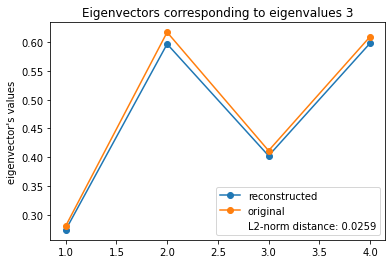

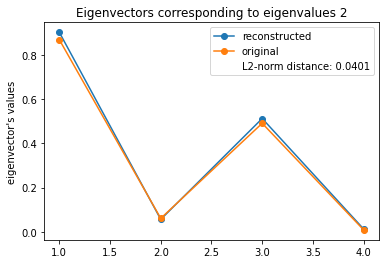

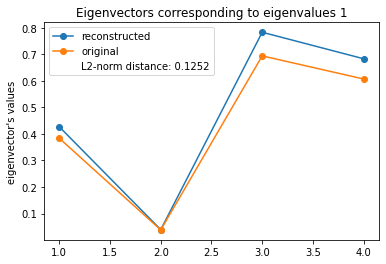

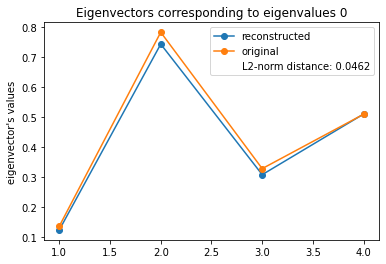

In [103]:
eigenvectors_benchmarking(example_matrix,eigenvectors)

## 1st matrix_example

In [501]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4063|0\rangle(|0\rangle-1.21|1\rangle)-0.4898|1\rangle(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle((0.4063|0\rangle-0.4898|1\rangle)(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle(0.4063(|0\rangle-y|1\rangle)(|0\rangle-x|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [643]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [672]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$


